<a href="https://colab.research.google.com/github/zloelias/hse-project-vae-lstm/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [6]:
!pip install sranodec
!pip install skorch
!pip install pytorch-lightning

     |████████████████████████████████| 133kB 4.1MB/s 
     |████████████████████████████████| 808kB 4.3MB/s 
     |████████████████████████████████| 276kB 41.7MB/s 
     |████████████████████████████████| 829kB 39.7MB/s 
     |████████████████████████████████| 645kB 34.8MB/s 
     |████████████████████████████████| 112kB 43.3MB/s 
     |████████████████████████████████| 1.3MB 37.4MB/s 
     |████████████████████████████████| 296kB 38.3MB/s 
     |████████████████████████████████| 143kB 41.3MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=21332e2b003583debb9fa79f7f161617b6662c096b80ed31dd74d7e82afd97cc
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfull

In [7]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sranodec import Silency
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pytorch_lightning as pl


In [8]:
class KPIDataset(Dataset):
    def __init__(self, X, label, window_len=256, sliding_step=1):
        self.start = 0
        self.window_len = window_len
        self.sliding_step = sliding_step
        self.df = X
        timeseries = ((self.df.value - self.df.value.mean()) / self.df.value.std()).values
        W = self.normality_weights(self.df.value)
        temp = []
        temp_W = []
        self.label = label.values[self.window_len-1:-1]
        self.y = [] 
        for i in range(self.start, len(timeseries) - self.window_len*self.sliding_step, self.sliding_step):
            temp.append(
                torch.unsqueeze(torch.tensor(timeseries[i:i+self.window_len]), 0)
            )
            #self.label.append(
            #    label[i+self.window_len-1]
            #)
            self.y.append(
                timeseries[i+self.window_len]
            )
            temp_W.append(
                torch.unsqueeze(torch.tensor(W[i:i+self.window_len]), 0)
            )
        self.features = torch.Tensor(len(temp), self.window_len)
        self.W = torch.Tensor(len(temp_W), self.window_len)
        #self.label = torch.Tensor(len(temp_label), self.window_len)
        torch.cat(temp, out=self.features)
        #torch.cat(temp_label, out=self.label)
        torch.cat(temp_W, out=self.W)
        #self.W = torch.ones(len(temp), 1, self.window_len)
        #self.W = torch.rand((len(temp), 1, self.window_len))

    def normality_weights(self, x):
        window = 1440
        saliency = Silency(window // 8, window // 8, window * 2)
        #S = np.real(saliency.transform_silency_map(x))
        #D = (S - S.mean()) / S
        #W = 1 - 1 / (1 + np.exp(-(D - 5)))
        D = saliency.generate_anomaly_score(x, type='abs')
        W = 1 - 1 / (1 + np.exp(-(D - 4)))
        return W

    def __getitem__(self, i):
        return self.features[i].unsqueeze(dim=0), self.W[i].unsqueeze(dim=0), self.label[i], self.y[i]
    
    def __len__(self):
        return len(self.features)

window_len = 256

BATCH_SIZE = 32768*4 #32768 #16384 #8192 #4096 #2048


In [9]:
 files = [
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/0.csv',
    #'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/2.csv',         
    #'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/4.csv',         
]

train_datasets = []
val_datasets = []
test_datasets = []

train_dataloaders = []
val_dataloaders = []
test_dataloaders = []

for file in files:
    df = pd.read_csv(file, index_col=0, header=0)
    y = df.label
    X = df.drop('label', axis=1).drop('KPI ID', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
    train_datasets.append(KPIDataset(X_train, y_train, window_len=window_len, sliding_step=1))
    val_datasets.append(KPIDataset(X_val, y_val, window_len=window_len, sliding_step=1))
    test_datasets.append(KPIDataset(X_test, y_test, window_len=window_len, sliding_step=1))

    train_dataloaders.append(DataLoader(train_datasets[-1], batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True))
    val_dataloaders.append(DataLoader(val_datasets[-1], batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True))
    test_dataloaders.append(DataLoader(test_datasets[-1], batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True))



/usr/local/lib/python3.7/dist-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


In [10]:
class CustomDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets

        self.map_indexes = [[] for _ in self.datasets]

        self.min_length = min(len(d) for d in self.datasets)
        self.max_length = max(len(d) for d in self.datasets)

    def __getitem__(self, i):
        return tuple(d[m[i]] for d, m in zip(self.datasets, self.map_indexes))

    def construct_map_index(self):
        def update_indices(original_indexes, target_len, max_len):
            # map max_len to target_len (large to small)

            # return: a list, which maps the range(max_len) to the valid index in the dataset
            
            original_indexes = original_indexes[max_len:] # remove used indices
            fill_num = max_len - len(original_indexes)
            batch = fill_num // target_len

            if fill_num % target_len != 0:
                # to let the fill_num + len(original_indexes) greater than max_len
                batch += 1

            additional_indexes = list(range(target_len)) * batch
            #random.shuffle(additional_indexes)

            original_indexes += additional_indexes

            assert len(original_indexes) >= max_len, "the length of matcing indexes is too small"

            return original_indexes

        self.map_indexes = [update_indices(m, len(d), self.max_length) 
            for m, d in zip(self.map_indexes, self.datasets)]

    def __len__(self):
        # will be called every epoch
        self.construct_map_index()
        return self.max_length

In [11]:
train_dataset = CustomDataset(train_datasets)
val_dataset = CustomDataset(val_datasets)
test_dataset = CustomDataset(test_datasets)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [9]:
def weighted_mse_loss(input, target, weights):
        return (weights * (input - target) ** 2).mean()


def loss_fn(recon_x, x, y_pred, y_true, mu, logvar, w, beta=0.1, lmbda=10):
    MSE = weighted_mse_loss(recon_x, x, w)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    lstm_loss = nn.MSELoss(reduction='mean')
    MSE_LSTM = lstm_loss(y_pred, y_true)

    return MSE + beta*w.mean()*KLD + lmbda*w.mean()*MSE_LSTM, MSE, KLD, MSE_LSTM

In [12]:
class VAE(pl.LightningModule):
    def __init__(self, h_dim : int=128, z_dim : int=32, k : float=20, beta : float=1, delay : int=7):
        super(VAE, self).__init__()
        self.k_ = k
        self.beta_ = beta
        self.delay_ = delay
        self.x_groundtruth = np.array([])
        self.x_recon = np.array([])
        self.mae_recon = np.array([])
        self.anomaly_groundtruth = np.array([])
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(16, 32, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(32, 64, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(64, 128, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Flatten(start_dim=1)
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (h_dim, 1)),
            nn.ConvTranspose1d(h_dim, 64, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=4),
            nn.Tanhshrink(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size(), device=self.device)
        #print(f'esp {esp.shape}')
        #print(f'srt {std.shape}')
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        #print(f'mu: {mu.shape}')
        #print(f'logvar: {logvar}')
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        #print(f'x {x.shape}')
        #print(f'h {h.shape}')
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z

    def step(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def loss(self, recon_x, x, mu, logvar, w, beta=0.1):
        recon_loss = torch.mean(w * (recon_x - x) ** 2)#.mean()#weighted_mse_loss(recon_x, x, w)
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + beta*w.mean()*KLD
        logs = {
            "recon_loss": recon_loss,
            "kl": KLD,
            "loss": loss,
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, mu, logvar, w)
            self.log_dict({f'recon_mae_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_step=True)
            self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
            #if self.trainer.current_epoch > 5:
            #    print(self['recon_mae'])
        return loss

    def training_epoch_end(self, processed_epoch_output):
        self.eval_mae_std()

    def validation_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, mu, logvar, w)
            self.log('val_loss', loss, on_epoch=True)
            self.log_dict({f'recon_mae_val_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_step=True)
            self.log_dict({f"val_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, mu, logvar, w)
            self.x_groundtruth = np.concatenate((self.x_groundtruth, x[:,0,-1].detach().cpu().numpy()))
            self.anomaly_groundtruth = np.concatenate((self.anomaly_groundtruth, l.detach().cpu().numpy()))
            self.x_recon = np.concatenate((self.x_recon, x_recon[:,0,-1].detach().cpu().numpy()))
            self.mae_recon = np.concatenate((self.mae_recon, torch.abs(x_recon[:,0,-1] - x[:,0,-1]).detach().cpu().numpy()))
        return loss

    def test_epoch_end(self, output):
        self.anomaly_pointwise = np.array([1 if mae > (self.k_ * self.mae_std_) else 0 for mae in self.mae_recon])
        self.anomaly_pointwise[0:window_len] = 0
        self.anomaly_adjusted = self.anomaly_pointwise
        self.adjust_detected_anomaly()

    def adjust_detected_anomaly(self):
        i = 0
        while i < self.anomaly_groundtruth.shape[0]:
            if self.anomaly_groundtruth[i] == 0:
                i += 1
                continue
            else:
                # get anomaly len
                len = 1
                while self.anomaly_groundtruth[i+len] == 1:
                    len += 1
                # check detected anomaly in delay window
                if sum(self.anomaly_pointwise[i:i+self.delay_])>0:
                    self.anomaly_adjusted[i:i+len] = 1
                i += len
 
    def eval_mae_std(self):
        self.mae_std_ = np.std([self.trainer.logged_metrics[k].detach().item() for k in self.trainer.logged_metrics.keys() if k.find('recon_mae_') == 0])

    def treshold(self):
        return self.k_ * self.mae_std_

    def detect_anomaly(x):
        return trus



In [ ]:
vae = VAE()

early_stop_callback = pl.callbacks.EarlyStopping(
   monitor='val_loss',
   min_delta=0.001,
   patience=10,
   verbose=False,
   mode='min'
)

trainer = pl.Trainer(gpus=0, callbacks=[early_stop_callback], check_val_every_n_epoch=1, min_epochs=50)
trainer.fit(vae, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 43.3 K
1 | fc1     | Linear     | 4.1 K 
2 | fc2     | Linear     | 4.1 K 
3 | fc3     | Linear     | 4.2 K 
4 | decoder | Sequential | 43.2 K
---------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


Metric val_loss improved. New best score: 0.920


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 11 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 12 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 13 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 14 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 16 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 17 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 18 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 19 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


Monitored metric val_loss did not improve in the last 20 records. Best score: 0.920. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...


In [83]:
trainer.test(test_dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

In [99]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'F1-score: {f1_score(vae.anomaly_adjusted, vae.anomaly_groundtruth)}, Precision: {precision_score(vae.anomaly_adjusted, vae.anomaly_groundtruth)}, Recall: {recall_score(vae.anomaly_adjusted, vae.anomaly_groundtruth)}')

Precision: 0.41025641025641024, Recall: 1.0, f1-score: 0.5818181818181819


In [95]:
vae.delay_ = 7
vae.adjust_detected_anomaly()

In [96]:
np.argwhere(vae.anomaly_adjusted > 0).reshape(-1)

array([ 4969,  4970,  4971,  4972,  4973,  4974,  4975,  6171,  6172,
        6173,  6174,  6175,  6176,  6179,  6180,  6181,  6189,  6190,
        6191,  6192,  6193,  9493, 19638, 19639, 19640, 19641, 19642,
       19643, 19644, 19645, 19646, 19647, 19648, 19649, 19650, 19651,
       19652, 19653, 19654, 19655, 19656, 19657, 20426, 20427, 20428,
       20429, 29712, 29713, 29714, 29715, 29716, 29717, 29718, 29719,
       29720, 29721, 29722, 29723, 29724, 29725, 29726, 29727, 29728,
       29729, 29730, 29731, 29732, 60003, 60004, 60005, 60006, 60007,
       60008, 60009, 60010, 60011, 60012, 60013, 60014, 60015, 60016,
       60017, 60018, 60019, 60020, 60021, 60022, 60023, 69921, 69922,
       69923, 69924, 69925, 69926, 69927, 69928, 69929, 69930, 69931,
       69932, 69933, 69934, 69935, 69936, 69937, 69938, 69939, 69940,
       69941, 69942, 69943, 69944, 69945, 69946, 69947, 69948, 69949,
       69950, 69951, 69952, 69953, 69954, 69955, 69956, 69957, 69958,
       69959, 69960,

In [92]:
np.argwhere(vae.anomaly_groundtruth > 0).reshape(-1)

array([ 4969,  4970,  4971,  4972,  4973,  4974,  4975,  6171,  6172,
        6173,  6174,  6175,  6176,  6179,  6180,  6181,  6189,  6190,
        6191,  6192,  6193,  6218,  6219,  6220,  6221,  6222,  6223,
        6238,  6239,  6240,  6241,  6242,  6243,  6247,  6248,  6249,
        9387,  9388,  9389,  9390,  9391,  9392,  9393,  9394,  9395,
        9396,  9397,  9398,  9399,  9400,  9401,  9402,  9403,  9404,
        9405,  9406,  9407,  9408,  9409,  9410,  9411,  9412,  9486,
        9487,  9488,  9489,  9490,  9491,  9492,  9493,  9494,  9495,
        9496,  9497,  9498,  9499,  9500,  9501,  9502,  9503,  9504,
        9505,  9600,  9601,  9602,  9603,  9604,  9605,  9606,  9607,
        9608,  9609,  9610,  9611,  9612,  9613,  9614, 12890, 12891,
       12892, 12893, 19536, 19537, 19538, 19539, 19540, 19541, 19542,
       19543, 19544, 19545, 19546, 19547, 19548, 19549, 19550, 19551,
       19552, 19553, 19554, 19555, 19556, 19557, 19558, 19559, 19560,
       19561, 19562,

In [4]:
import numpy as np
vae.anomaly_pointwise = np.array([1 if mae > (20 * vae.mae_std_) else 0 for mae in vae.mae_recon])
vae.anomaly_pointwise[0:window_len] = 0
vae.anomaly_adjusted = self.anomaly_pointwise
vae.adjust_detected_anomaly()


NameError: ignored

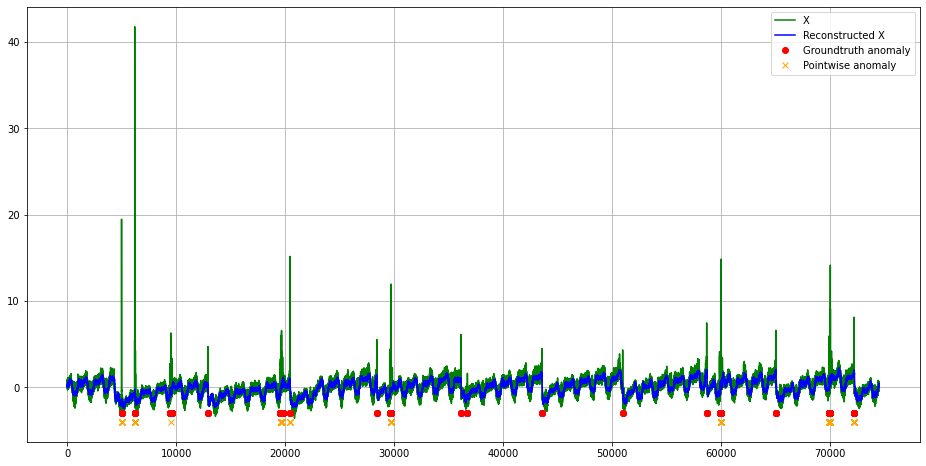

In [98]:

fig, ax = plt.subplots(figsize=(16, 8))

ts = range(len(vae.x_groundtruth))
ts_anomaly = np.argwhere(vae.anomaly_groundtruth > 0).reshape(-1)
pointwise_anomaly = np.argwhere(vae.anomaly_adjusted > 0).reshape(-1)

ax.plot(ts, vae.x_groundtruth[ts], color='green', label='X')
ax.plot(ts, vae.x_recon[ts], color='blue', label='Reconstructed X')
#ax.plot(ts, Y[ts], color='yellow', label='Predicted X')
ax.plot(ts_anomaly, [-3]*len(ts_anomaly), 'o', color='red', label='Groundtruth anomaly')
ax.plot(pointwise_anomaly, [-4]*len(pointwise_anomaly), 'x', color='orange', label='Pointwise anomaly')
ax.legend()

ax.grid()

plt.show()


In [9]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.3)
        
        self.fc1 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanhshrink()
        #self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc1(h_out)
        out = self.tanh(out)
        #out = self.fc2(out)
        
        return out

In [10]:
class VAE_LSTM(nn.Module):

    def __init__(self, vae_h_dim=128, vae_z_dim=32, lstm_input_size=256, lstm_hidden_size=128):
        super(VAE_LSTM, self).__init__()
        self.vae = VAE(vae_h_dim, vae_z_dim)
        self.lstm = LSTM(lstm_input_size, lstm_hidden_size)
        
    def forward(self, x):
          x_recon, mu, logvar = self.vae(x)
          x_next = self.lstm(x_recon)
          return x_recon, x_next, mu, logvar



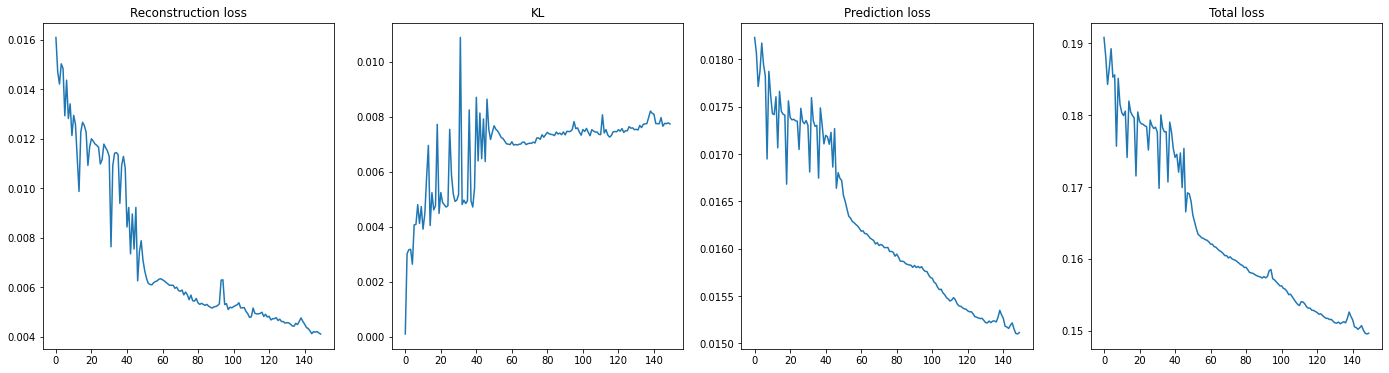

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vae_lstm = VAE_LSTM().to(device)

optimizer = torch.optim.Adam(vae_lstm.parameters(), lr=1e-3)

epochs = 150

loss_history, mse_history, kld_history, mse_lstm_history = [], [], [], []

for epoch in range(epochs):
    total_loss, total_mse, total_kld, total_mse_lstm = 0, 0, 0, 0
    mae_total = []
    for idx, (x, w, l, y_true) in enumerate(train_dataloader):
        #w.to(device)
        x_recon, x_next, mu, logvar = vae_lstm(x)
        loss, mse, kld, mse_lstm = loss_fn(x_recon, x, x_next.float(), y_true.float(), mu, logvar, w)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mae_total.append(torch.abs(x_recon - x).sum().detach().numpy() / (x.shape[0] * x.shape[2]))

        total_loss += loss.item() / BATCH_SIZE
        total_mse += mse.item() / BATCH_SIZE
        total_kld += kld.item() / BATCH_SIZE
        total_mse_lstm += mse_lstm.item() / BATCH_SIZE
    
    loss_history.append(total_loss)
    mse_history.append(total_mse)
    kld_history.append(total_kld)
    mse_lstm_history.append(total_mse_lstm)

    fig, ax = plt.subplots(ncols=4, figsize=(24,6))

    ax[0].plot(mse_history)
    ax[0].set_title('Reconstruction loss')
    ax[1].plot(kld_history)
    ax[1].set_title('KL')
    ax[2].plot(mse_lstm_history)
    ax[2].set_title('Prediction loss')
    ax[3].plot(loss_history)
    ax[3].set_title('Total loss')
    plt.show()
    plt.pause(0.3);
    clear_output(wait=True);

vae_lstm.vae.set_mae_std(np.std(mae_total))

In [13]:
import pickle

with open('/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/vae_lstm.pcl', 'wb') as f:
    pickle.dump(vae_lstm, f)


In [25]:
test_dataset = KPIDataset(X_test, y_test, window_len=window_len, sliding_step=1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)


X, L, Y = [], [], []
skip = 0
#MAE_total = []
X = np.array([])
X_recon = np.array([])
MAE = np.array([])
L = np.array([])
Y = np.array([])
for x, w, l, y in test_dataloader:
    x_recon, y_pred, _, _ = vae_lstm(x)
    #MAE_total.append(torch.abs(x_recon - x).sum().detach().numpy() / (x.shape[0] * x.shape[2]))
    X = np.concatenate((X, x[:,0,-1].detach().numpy()))
    X_recon = np.concatenate((X_recon, x_recon[:,0,-1].detach().numpy()))
    MAE = np.concatenate((MAE, torch.abs(x_recon[:,0,-1] - x[:,0,-1]).detach().numpy()))
    L = np.concatenate((L, l.detach().numpy()))
    Y = np.concatenate((Y, y_pred.squeeze().detach().numpy()))



/usr/local/lib/python3.7/dist-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


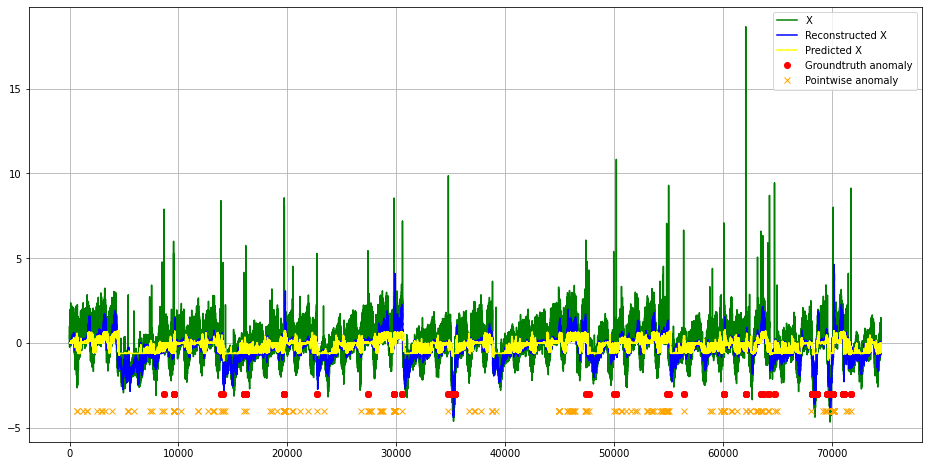

In [26]:

fig, ax = plt.subplots(figsize=(16, 8))

ts = range(len(X))
ts_anomaly = np.argwhere(L > 0).reshape(-1)
pointwise_anomaly = np.argwhere(MAE > vae_lstm.vae.treshold())

ax.plot(ts, X[ts], color='green', label='X')
ax.plot(ts, X_recon[ts], color='blue', label='Reconstructed X')
ax.plot(ts, Y[ts], color='yellow', label='Predicted X')
ax.plot(ts_anomaly, [-3]*len(ts_anomaly), 'o', color='red', label='Groundtruth anomaly')
ax.plot(pointwise_anomaly, [-4]*len(pointwise_anomaly), 'x', color='orange', label='Pointwise anomaly')
ax.legend()

ax.grid()

plt.show()


In [9]:
# AD
# P-AD
# PAD-
# PAD

# hyper - beta, lamda
# window_len
# k - treashold

In [26]:
weighted_mse_loss(torch.tensor([[[2, 2], [4, 4], [6, 6]]]).float(), torch.tensor([[[1, 1], [1, 1], [1, 1]]]).float(), torch.tensor([[[0], [0], [1]]]).float())

tensor(8.3333)